## 封装上述的建模预测过程

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
from sklearn.preprocessing import Imputer, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error 
from timeseriesutil import TimeSeriesDiff, TimeSeriesEmbedder, ColumnExtractor
from sklearn.neural_network import  MLPRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt 
import matplotlib 
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']='SimHei'#设置中文字符的正常显示
plt.rcParams['axes.unicode_minus'] = False#设置中文字体符号的正常显示

data = pd.read_csv("600000.SH(1).csv",encoding='gbk')#读取数据
data['日期']=pd.to_datetime(data['日期'])#将日期转换为时间序列格式


data['diff_close']=data["收盘价(元)"]-data['前收盘价(元)']#新建特征变量
data['max_min']=data["最高价(元)"]-data["最低价(元)"]#新建特征变量
data=data[['日期','收盘价(元)',"成交量(股)","diff_close","max_min"]]#取时间列与收盘价数据作为特征列
data.rename(columns={"日期":"date",'收盘价(元)':"Close","成交量(股)":"Volume"},inplace=True)#修改两列的名称方便调用
data=data.set_index(['date'])#将日期列作为索引
data

,Close,Volume,diff_close,max_min
date,,,,
1999-11-10,3.3904,174085100.0,NaN,0.3421
1999-11-11,3.3856,29403500.0,-0.0048,0.1038
1999-11-12,3.4271,15008000.0,0.0415,0.0647
1999-11-15,3.3904,11921100.0,-0.0367,0.0672
1999-11-16,3.2438,23223100.0,-0.1466,0.1820
...,...,...,...,...
2016-06-02,18.0200,17786525.0,-0.1700,0.3700
2016-06-03,18.0100,18003512.0,-0.0100,0.2300
2016-06-06,18.0200,17856247.0,0.0100,0.1400


In [11]:
y
y_train=y[10:n_train]
y_train

date
1999-11-24   -0.000743
1999-11-25   -0.001146
1999-11-26    0.001891
1999-11-29   -0.004518
1999-11-30    0.002642
                ...   
2015-08-06    0.004572
2015-08-07    0.005852
2015-08-10    0.020039
2015-08-11   -0.013308
2015-08-12   -0.011561
Name: Close, Length: 3803, dtype: float64

In [16]:
y = data["Close"].diff() / data["Close"].shift()#股价变化率
y[np.isnan(y)]=0#将缺失值赋值为0

n_total = data.shape[0]#样本个数
n_train = int(n_total*0.95)#划分95%的数据作为训练集

data_train = data[:n_train]
data_test  = data[n_train:]
y_train = y[10:n_train]
y_test  = y[n_train+10:]

#选择特征变量收盘价
def build_model(name,model):
    '''对收盘价列作数据预处理
    1.选取特征列
    2.作时间序列差分
    3.将2中的结果转换为列表形式
    4.填补上述计算中产生的缺失值
    '''
    pipeline_closing_price = Pipeline([("ColumnEx", ColumnExtractor("Close")),
                                       ("Diff", TimeSeriesDiff()),
                                       ("Embed", TimeSeriesEmbedder(10)),
                                       ("ImputerNA", Imputer())])
    pipeline_volume = Pipeline([("ColumnEx", ColumnExtractor("Volume")),
                                       ("Diff", TimeSeriesDiff()),
                                       ("Embed", TimeSeriesEmbedder(10)),
                                       ("ImputerNA", Imputer())])
    pipeline_diff_close = Pipeline([("ColumnEx", ColumnExtractor("diff_close")),
                                       ("Diff", TimeSeriesDiff()),
                                       ("Embed", TimeSeriesEmbedder(10)),
                                       ("ImputerNA", Imputer())])
    pipeline_max_min= Pipeline([("ColumnEx", ColumnExtractor("max_min")),
                                       ("Diff", TimeSeriesDiff()),
                                       ("Embed", TimeSeriesEmbedder(10)),
                                       ("ImputerNA", Imputer())])
    #将处理完毕的数据作为特征
    merged_features = FeatureUnion([("ClosingPriceFeature", pipeline_closing_price),
                                  ("VolumePriceFeature", pipeline_volume),
                                  ("DiffClosePriceFeature", pipeline_diff_close),
                                  ("MaxMinPriceFeature", pipeline_max_min)])
    
    #建立模型，标准化特征值
    pipeline_2 = Pipeline([("MergedFeatures", merged_features),
                            ('StandardScaler',StandardScaler()),
                           ("Moder Method",model)])
    if (name=="逻辑回归"):
        pipeline_2.fit(data_train, y_train.astype('int'))
    else:
        pipeline_2.fit(data_train, y_train)
    y_pred_2 = pipeline_2.predict(data_test)#预测结果


    #可视化结果
    plt.figure(figsize=(8,6))
    plot_train=(y_train+1)* data["Close"].shift()
    plot_train.plot(style="b", rot=10)#绘制测试集的数据

    plot_test=(y_test+1)* data["Close"].shift()
    plot_test.plot(style="y", rot=10)#绘制测试集的数据

    cc_2 = np.sign(y_pred_2)*y_test#每笔交易的理论收益
    cumulative_return_2 = (cc_2+1).cumprod()* data["Close"].shift()
    cumulative_return_2.plot(style="r", rot=10)#绘制预测的数据
    
    plt.legend(['训练集','测试集','预测数据'])
    plt.title('股价变化预测模型--'+name)
    plt.show()
    
    
    #模型评估
    print("预测值：",cumulative_return_2.drop_duplicates().tolist()[1:])
    print("=============================================")

## 分别使用支持向量机、决策树、神经网络、逻辑回归对股价进行预测

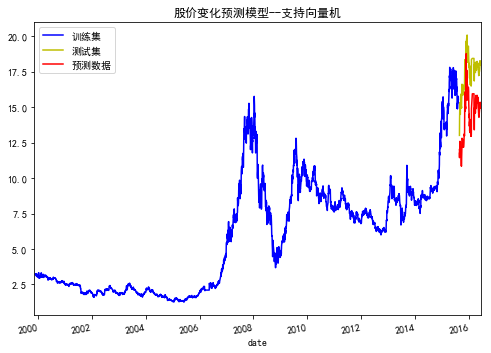

预测值： [11.760000000000002, 11.446779661016949, 12.062197922361948, 11.665301567262771, 11.952018951289597, 12.599153667235088, 12.55806053720497, 11.756841093931314, 12.129816742428446, 12.137871069614654, 11.961727821902567, 11.914665286209837, 11.838092887198206, 11.511114803684887, 11.250513886395773, 10.958860901654468, 10.857322812559062, 10.871770347905116, 10.85724560462134, 11.015956171599194, 11.487542255199426, 11.97653390325965, 12.268457115782978, 12.815605642931589, 12.735357642662759, 12.176319093105104, 12.322097330514682, 12.37634555775594, 12.25304448121541, 12.199336709538198, 12.490893184357349, 12.820841306208296, 12.844466935150939, 13.056967307239834, 13.121011291579453, 12.978649505414035, 13.034079979201648, 13.375618942702971, 14.391385873345662, 15.28016504842164, 15.65979647819609, 16.088951974522494, 15.716645647839329, 14.85252958336912, 14.72687366472809, 15.049236106697942, 14.89514836499114, 14.955002577709244, 15.349457920928636, 16.30273075328073, 17.35

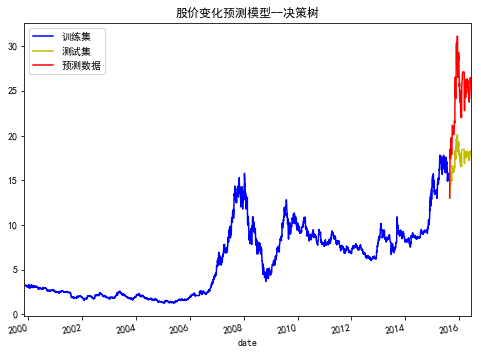

预测值： [13.02, 14.690847457627118, 16.067409200968523, 17.193736884584343, 18.509830508474575, 18.42322033898305, 17.425746569814365, 17.62469733656174, 18.183825665859562, 18.413236481033085, 18.899073855202825, 19.741786656615147, 19.614911421032787, 18.9992519288472, 18.56912656176463, 18.087749333980714, 17.92015933353351, 17.944005187603416, 17.920031900779634, 18.181985855475414, 18.96034511617804, 19.767432498333623, 20.249255740756123, 21.152331844772252, 21.019881426207615, 20.09718067809387, 20.337789646514658, 20.427327085210006, 20.22381697726271, 20.135171567844527, 20.616389504686094, 21.16097337839478, 21.199967801082234, 21.550702562497197, 21.656408031841146, 21.421437962779578, 21.51292671551872, 22.07664143140373, 23.753178599645207, 25.220120745941582, 25.846707596772426, 26.555034594670552, 25.940537926364126, 24.51430258038548, 24.306905773444818, 24.3909158164406, 24.19667644133812, 24.155005930819165, 24.79212191293939, 26.331828161701583, 28.038248310728054, 28.9

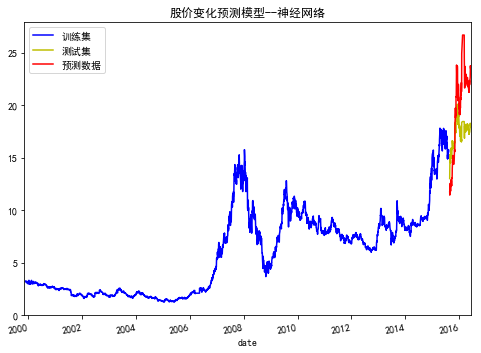

预测值： [11.760000000000002, 11.446779661016949, 12.062197922361948, 11.665301567262771, 12.55822142037488, 12.499459689129809, 11.82271138241241, 11.957691969048414, 12.337039438411328, 12.492686018311602, 12.31139374100101, 12.262955470544613, 12.924965920111285, 12.56796748917287, 12.803718496408328, 12.47180097219813, 12.356244907598017, 12.372687016590165, 12.356157040616097, 12.53677860532942, 13.073470130908738, 13.06490859185772, 13.383360501088374, 13.980231478209776, 15.22330778998547, 14.500132014033063, 14.381353364894798, 14.607475273147857, 14.461946254237295, 14.398556383367126, 14.742672825233763, 15.057924948540649, 15.08567296748759, 15.33525211584676, 15.786565482836734, 15.577219828453124, 15.643748528147555, 16.05367003132266, 17.272812652170373, 18.339542174632196, 18.79518297400194, 18.847742210506418, 19.740803273924357, 19.450655376049582, 18.803397244528472, 19.21499234550317, 19.018251809542388, 19.094674176170862, 19.598318105129493, 20.81546494547106, 20.79220

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [17]:
models={"支持向量机":SVR(kernel='rbf',C=1000),
        "决策树":DecisionTreeRegressor(max_depth=4),
        "神经网络":MLPRegressor(random_state=0),
        "逻辑回归":LogisticRegression()
       }

for name,model in models.items():
    build_model(name,model)